# 1.0.0 Introduction

**Setting the context for this notebook.**

* This notebook is to be read in conjunction with the [phase-3 report](https://docs.google.com/document/d/1rEzVLKu58aJ8w2eq2bBznYF5v6Cn5kLHqVqOn_-kqPs/edit?usp=sharing) about the Home Credit loan defaulter prediction problem hosted on Kaggle [here](https://www.kaggle.com/c/home-credit-default-risk/data).
* This notebook is building on the key insights and preliminary feature engineering from the previous EDA phase and directly dwells into the modelling.
* An understanding of the dataset preparation process along with the logic used can be gained here. 
* An understanding of the complete problem context and high level summary of the datasets used can be sought from [here.](https://docs.google.com/document/d/1qcbp5zqYPSARrVfMg2flBY-Zgbp7j_IWExBpGuZIrkI/edit?usp=sharing)

**A quick refresher about Home Credit's motivation for this problem**

Though there are a lot of people seeking loans from banks and lending institutions, only a few of them get approved. This is primarily because of insufficient or non-existent credit histories of the applicant. Such population is taken advantage of by untrustworthy lenders.
In order to make sure that these applicants have a positive loan taking experience, Home Credit uses Data Analytics to predict the applicants' loan repayment abilities, trying to ensure that the clients capable of loan repayment do not have their applications rejected.

**Summary of approach**

>Primarily, the processed datasets are used, which are inherently imbalanced. 
>
>This dataset was found to be most optimal from the previous phase.
>
>The previous phase of error analysis highlighted the need for advanced feature engineering which shall be done here.


# 2.0.0 Necessary groundwork for carrying out the Advanced Modeling and Feature Engineering

>Mounting Google Drive to acess processed datasets from previous phases

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.1.0 Installing dependencies for libraries used in this notebook

In [ ]:
#Libraries for model explainability [LIME & SHAP] and modeling pipeline [PyCaret]
%%capture
!pip install lime
!pip install pycaret[full]
!pip install --upgrade pycaret
!pip install shap
!pip install matplotlib==3.1.1 #to resolve version compatibility errors for mlxtend

## 2.2.0 Importing the necessary libraries

In [ ]:
#Importing all required libraries.

#The essential basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#For plotting a neat Confusion Matrix
from mlxtend.plotting import plot_confusion_matrix

#LIME for model explainability
from lime.lime_tabular import LimeTabularExplainer

#PyCaret pipeline for modeling and comparisons
from pycaret.classification import *
from pycaret.utils import enable_colab 
enable_colab()

#PCA and LDA for advanced feature engineering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#Library for creating Deep Neural Networks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

Colab mode enabled.


## 2.3.0 Importing the Processed Datsets for Modeling

### 2.3.1 Custom function for optimizing size of the loaded datasets

In [ ]:
#Function for reducing the size of the Pandas Dataframe
def df_size_optimizer(df):
  """This function accepts a Pandas DataFrame and each feature variable type is checked and assigned appropriately. This is primarily done to optimize the size the dataframe occupies on system RAM."""
  #Source ref [1] & Code Credit - https://www.kaggle.com/rinnqd/reduce-memory-usage
  #Source ref [2] - https://www.analyticsvidhya.com/blog/2021/04/how-to-reduce-memory-usage-in-python-pandas/ [For understanding the logic and implementation]  
  for col in df.columns:
    col_type=df[col].dtype
    if col_type!=object:
      c_min=df[col].min()
      c_max=df[col].max()
      if str(col_type)[:3]=='int':
        if c_min>np.iinfo(np.int8).min and c_max<np.iinfo(np.int8).max:
          df[col]=df[col].astype(np.int8)
        elif c_min>np.iinfo(np.int16).min and c_max<np.iinfo(np.int16).max:
          df[col]=df[col].astype(np.int16)
        elif c_min>np.iinfo(np.int32).min and c_max<np.iinfo(np.int32).max:
          df[col]=df[col].astype(np.int32)
        elif c_min>np.iinfo(np.int64).min and c_max<np.iinfo(np.int64).max:
          df[col]=df[col].astype(np.int64)  
      else:
        if c_min>np.finfo(np.float16).min and c_max<np.finfo(np.float16).max:
          df[col]=df[col].astype(np.float16)
        elif c_min>np.finfo(np.float32).min and c_max<np.finfo(np.float32).max:
          df[col]=df[col].astype(np.float32)
        else:
          df[col]=df[col].astype(np.float64)
  return df

### 2.3.2 Loading the processed datasets

In [ ]:
#Loading the required processed datasets

X_train_selected_features = df_size_optimizer(pd.read_csv('/content/drive/MyDrive/Data/X_train_final_feature_selected.csv'))
y_train_selected_features = df_size_optimizer(pd.read_csv('/content/drive/MyDrive/Data/y_train_final_feature_selected.csv'))
X_test_selected_features = df_size_optimizer(pd.read_csv('/content/drive/MyDrive/Data/X_test_final_feature_selected.csv'))
y_test_selected_features = df_size_optimizer(pd.read_csv('/content/drive/MyDrive/Data/y_test_final_feature_selected.csv'))
test_predict=df_size_optimizer(pd.read_csv('/content/drive/MyDrive/Data/predict_test.csv'))

# 3.0.0 Creation of Additional Features

##  3.1.0 Data preparation for the PyCaret pipeline

In [ ]:
#Prepare data frame of correctly predicted data points
predict_test_without_labels=test_predict.drop(columns=['TARGET', 'Label', 'Score'])

## 3.2.0 PCA with 5 features for visualization as possible feature

In [ ]:
pca=PCA(n_components=5, random_state=7)
predict_test_without_labels_PCA=pca.fit_transform(predict_test_without_labels)

In [ ]:
predict_test_without_labels_PCA= pd.DataFrame(predict_test_without_labels_PCA, columns=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'])

In [ ]:
test_predict_PCA=predict_test_without_labels_PCA
test_predict_PCA['TARGET']=test_predict['TARGET']
test_predict_PCA['Label']=test_predict['Label']
test_predict_PCA['Score']=test_predict['Score']

test_predict_PCA['PRED']=np.where(test_predict_PCA['Label']==test_predict_PCA['TARGET'], 'Correct', 'Wrong')

case_checks=[(test_predict_PCA['Label'] == 0) & (test_predict_PCA['TARGET'] == 0), (test_predict_PCA['Label'] == 0) & (test_predict_PCA['TARGET'] != 0), 
             (test_predict_PCA['Label'] == 1) & (test_predict_PCA['TARGET'] == 1), (test_predict_PCA['Label'] == 1) & (test_predict_PCA['TARGET'] != 1)]
values = ['Correct_0', 'Wrong_0', 'Correct_1', 'Wrong_1']

test_predict_PCA['pred_case'] = np.select(case_checks, values)

test_predict_PCA

PCA_1     PCA_2     PCA_3     PCA_4     PCA_5  TARGET  Label  \
0     -0.209090 -0.215444 -0.055032 -2.110138  1.820968       0      0   
1     -0.592357  0.220894 -0.049130  4.366654  1.733111       1      0   
2     -0.811496  1.378035 -0.129446  0.816077  0.099191       0      0   
3     -0.528212  0.290050 -0.074455 -0.069617 -1.370033       0      0   
4     -0.700183  1.389499 -0.100750 -1.512780 -0.170013       0      0   
...         ...       ...       ...       ...       ...     ...    ...   
46122  1.132474 -6.799023  0.383692  1.144583  1.499022       0      0   
46123 -0.511721  0.411150 -0.043567 -0.833667 -0.770750       0      0   
46124 -0.960414  2.456613 -0.239037 -0.126781  2.894498       0      0   
46125 -0.925649  1.866711 -0.128473  0.367644 -0.649557       0      0   
46126 -0.343606 -0.448144 -0.004862  2.400629  0.806302       0      0   

          Score     PRED       TYPE  pred_case  
0      0.916992  Correct  Correct_0  Correct_0  
1      0.989258    Wrong    Wrong_0    Wrong_0  
2      0.981934  Correct  Correct_0  Correct_0  
3      0.878906  Correct  Correct_0  Correct_0  
4      0.988281  Correct  Correct_0  Correct_0  
...         ...      ...        ...        ...  
46122  0.983887  Correct  Correct_0  Correct_0  
46123  0.991211  Correct  Correct_0  Correct_0  
46124  0.678223  Correct  Correct_0  Correct_0  
46125  0.973145  Correct  Correct_0  Correct_0  
46126  0.957520  Correct  Correct_0  Correct_0  

[46127 rows x 11 columns]

### 3.2.1 Visualization of the 5-component PCA features

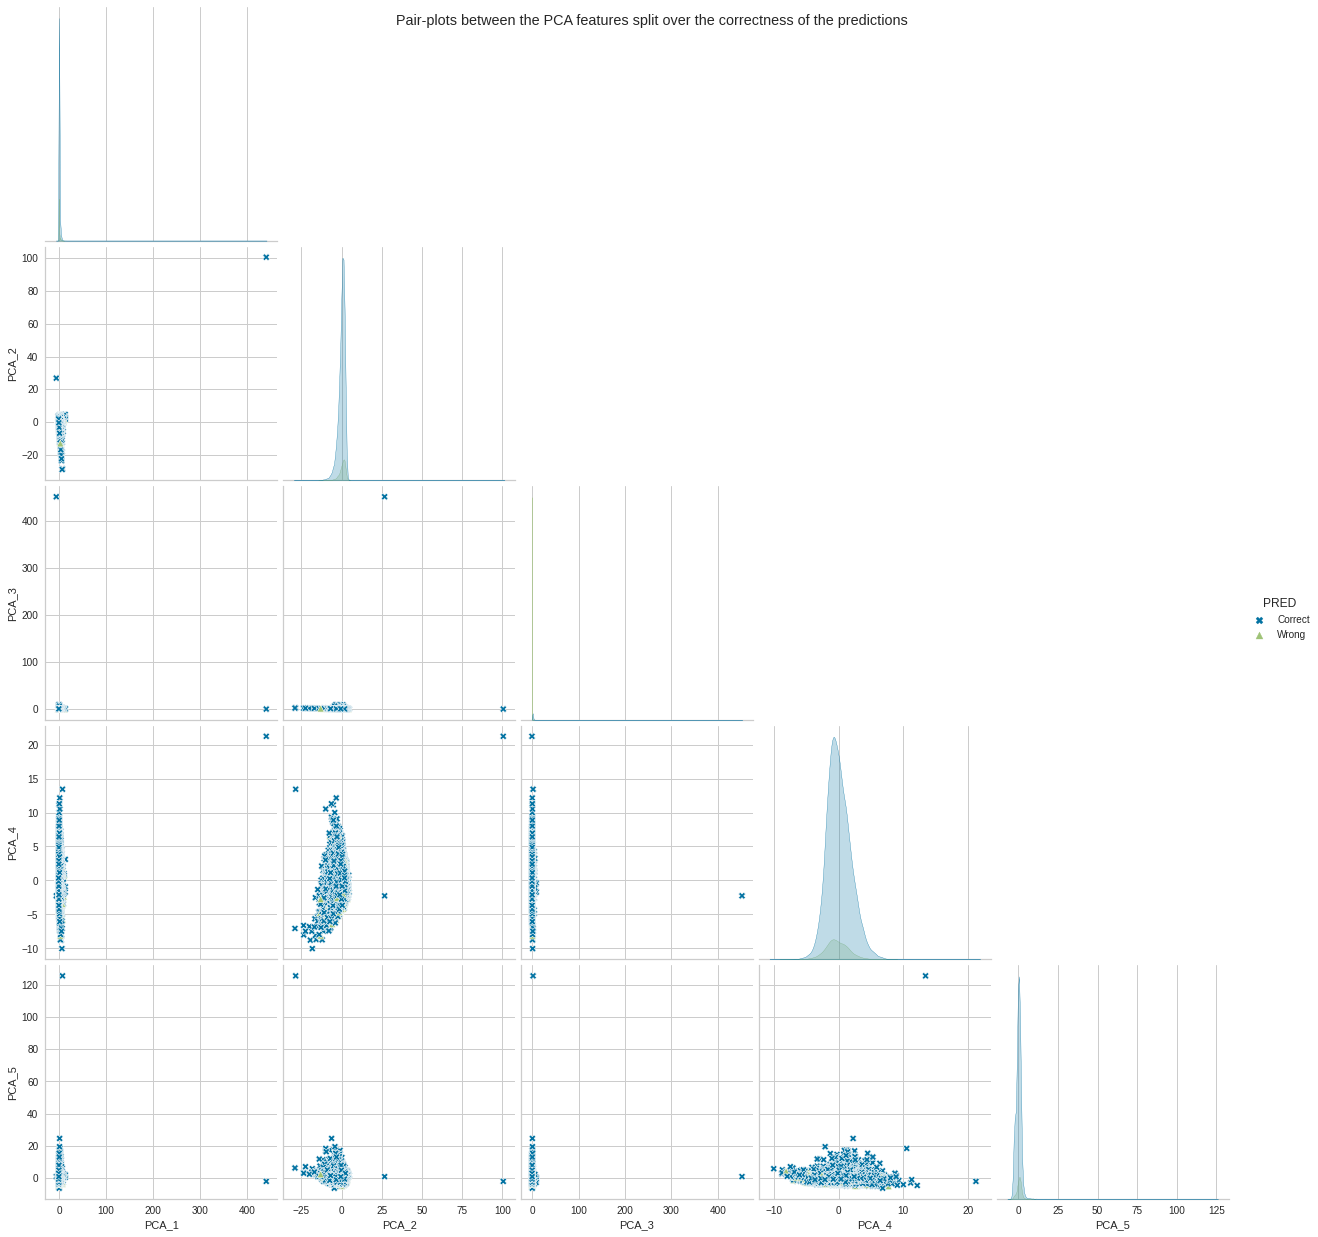

In [ ]:
p_plot=sns.pairplot(test_predict_PCA.drop(columns=['TARGET', 'Label', 'Score']), hue='PRED', markers=["X", "^"], corner=True, height=3.5)
p_plot.fig.suptitle("Pair-plots between the PCA features split over the correctness of the predictions")
plt.show()

>* Though the features are plotted, there is novisually distinct separability between classes based on errors.

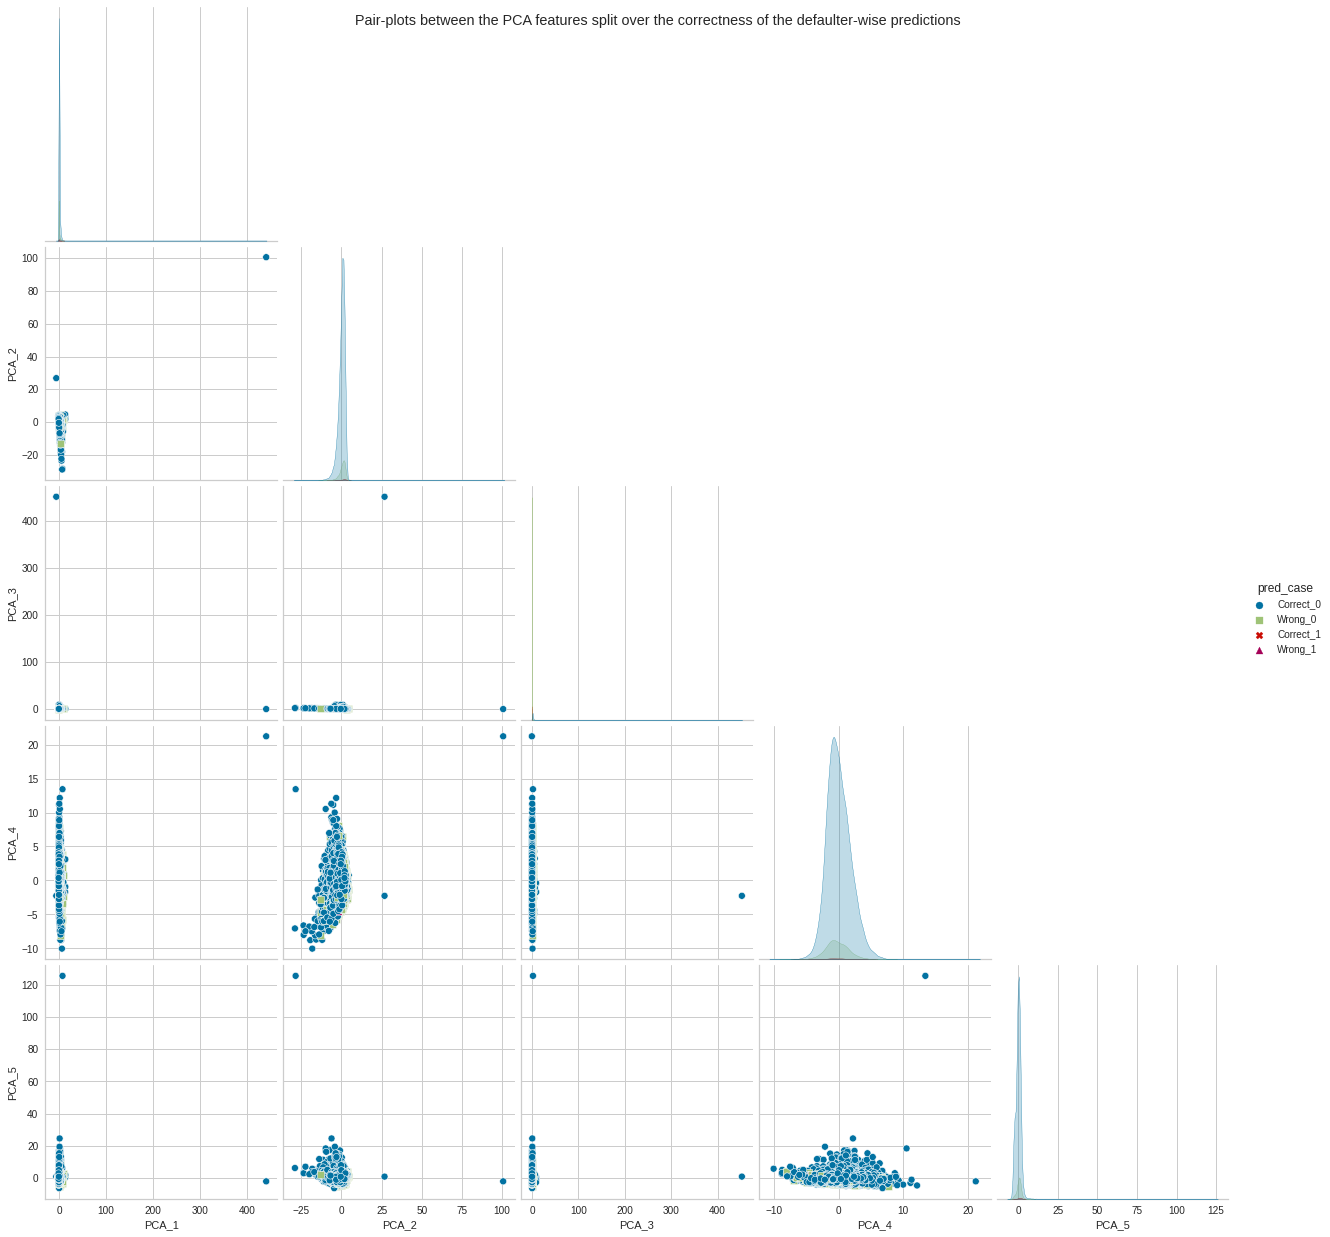

In [ ]:
p_plot=sns.pairplot(test_predict_PCA.drop(columns=['TARGET', 'Label', 'Score']), hue='pred_case', markers=["o", "s", "X", "^"], corner=True, height=3.5)
p_plot.fig.suptitle("Pair-plots between the PCA features split over the correctness of the defaulter-wise predictions")
plt.show()

>* Plotting with context to class based errors also shows no new insights towards error reduction, visually.

## 3.3.0 PCA with 2 features for visualization as possible feature

In [ ]:
pca_2f=PCA(n_components=2, random_state=7)
predict_test_without_labels_PCA_2f=pca_2f.fit_transform(predict_test_without_labels)

In [ ]:
predict_test_without_labels_PCA_2f=pd.DataFrame(predict_test_without_labels_PCA_2f, columns=['PCA_1', 'PCA_2'])

In [ ]:
test_predict_PCA_2f=predict_test_without_labels_PCA_2f
test_predict_PCA_2f['TARGET']=test_predict['TARGET']
test_predict_PCA_2f['Label']=test_predict['Label']
test_predict_PCA_2f['Score']=test_predict['Score']

test_predict_PCA_2f['PRED'] = np.where(test_predict_PCA_2f['Label']==test_predict_PCA_2f['TARGET'], 'Correct', 'Wrong')

case_checks=[(test_predict_PCA_2f['Label'] == 0) & (test_predict_PCA_2f['TARGET'] == 0), (test_predict_PCA_2f['Label'] == 0) & (test_predict_PCA_2f['TARGET'] != 0), 
              (test_predict_PCA_2f['Label'] == 1) & (test_predict_PCA_2f['TARGET'] == 1), (test_predict_PCA_2f['Label'] == 1) & (test_predict_PCA_2f['TARGET'] != 1)]
values=['Correct_0', 'Wrong_0', 'Correct_1', 'Wrong_1']

test_predict_PCA_2f['pred_case']=np.select(case_checks, values)

test_predict_PCA_2f

PCA_1     PCA_2  TARGET  Label     Score     PRED  pred_case
0     -0.209076 -0.215372       0      0  0.916992  Correct  Correct_0
1     -0.592332  0.220929       1      0  0.989258    Wrong    Wrong_0
2     -0.811483  1.378032       0      0  0.981934  Correct  Correct_0
3     -0.528237  0.290024       0      0  0.878906  Correct  Correct_0
4     -0.700187  1.389442       0      0  0.988281  Correct  Correct_0
...         ...       ...     ...    ...       ...      ...        ...
46122  1.132490 -6.799055       0      0  0.983887  Correct  Correct_0
46123 -0.511719  0.411074       0      0  0.991211  Correct  Correct_0
46124 -0.960411  2.456518       0      0  0.678223  Correct  Correct_0
46125 -0.925661  1.866721       0      0  0.973145  Correct  Correct_0
46126 -0.343608 -0.448127       0      0  0.957520  Correct  Correct_0

[46127 rows x 7 columns]

### 3.3.1 Visualization of the 2-component PCA features

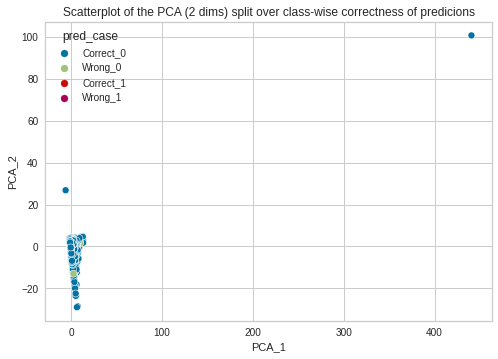

In [ ]:
sns.scatterplot(data=test_predict_PCA_2f, x="PCA_1", y="PCA_2", hue='pred_case')
plt.title("Scatterplot of the PCA (2 dims) split over class-wise correctness of predicions")
plt.show()

>* Plotting with context to 2 component-PCA also shows no new insights towards error reduction, visually atleast.

## 3.4.0 Training the lGBM model with prediction confidence as output

### 3.4.1 Creation of the additional feature

In [ ]:
#Data preparation
X_train_selected_features_with_target=X_train_selected_features
X_train_selected_features_with_target["TARGET"]=y_train_selected_features.to_numpy().flatten()
X_test_selected_features_with_target=X_test_selected_features
X_test_selected_features_with_target["TARGET"]=y_test_selected_features.to_numpy().flatten()

#Rename columns to enable pycaret to read them
X_train_selected_features_with_target=X_train_selected_features_with_target.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_selected_features_with_target=X_test_selected_features_with_target.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#Setup the dataset
data_selected_features=setup(data=X_train_selected_features_with_target, target="TARGET", test_data=X_test_selected_features_with_target, preprocess=False, silent=True)

Description             Value
0              session_id              7537
1                  Target            TARGET
2             Target Type            Binary
3           Label Encoded              None
4           Original Data     (204494, 177)
5          Missing Values             False
6        Numeric Features               176
7    Categorical Features                 0
8   Transformed Train Set     (204494, 176)
9    Transformed Test Set      (46127, 176)
10     Shuffle Train-Test              True
11    Stratify Train-Test             False
12         Fold Generator   StratifiedKFold
13            Fold Number                10
14               CPU Jobs                -1
15                Use GPU             False
16         Log Experiment             False
17        Experiment Name  clf-default-name
18                    USI              82e3
19          Fix Imbalance             False
20   Fix Imbalance Method             SMOTE

In [ ]:
best_model=create_model('lightgbm', bagging_fraction=0.7, bagging_freq=5, boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
                        importance_type='split', learning_rate=0.05, max_depth=-1, min_child_samples=81, min_child_weight=0.001, min_split_gain=0.2,
                        n_estimators=300, n_jobs=-1, num_leaves=200, objective=None, random_state=3067, reg_alpha=0.0005, reg_lambda=0.0005,
                        silent='warn', subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9169  0.7662  0.0287  0.3902  0.0535  0.0427  0.0875
1       0.9187  0.7720  0.0454  0.5390  0.0838  0.0720  0.1390
2       0.9194  0.7662  0.0460  0.5923  0.0854  0.0745  0.1490
3       0.9181  0.7624  0.0335  0.4956  0.0627  0.0529  0.1125
4       0.9185  0.7657  0.0371  0.5254  0.0693  0.0591  0.1234
5       0.9182  0.7689  0.0329  0.5000  0.0617  0.0522  0.1123
6       0.9191  0.7643  0.0425  0.5680  0.0790  0.0684  0.1392
7       0.9174  0.7542  0.0275  0.4220  0.0517  0.0421  0.0909
8       0.9188  0.7589  0.0389  0.5508  0.0726  0.0625  0.1304
9       0.9186  0.7681  0.0383  0.5333  0.0714  0.0611  0.1266
Mean    0.9184  0.7647  0.0371  0.5117  0.0691  0.0588  0.1211
SD      0.0007  0.0049  0.0061  0.0598  0.0111  0.0107  0.0193

In [ ]:
#Predict on train data
train_predict=predict_model(best_model, X_train_selected_features_with_target)
train_predict

NAME_HOUSING_TYPE_Municipalapartment  ...   Score
0                                          0  ...  0.9628
1                                          0  ...  0.9454
2                                          0  ...  0.9823
3                                          0  ...  0.9801
4                                          0  ...  0.7530
...                                      ...  ...     ...
204489                                     0  ...  0.9930
204490                                     0  ...  0.9464
204491                                     0  ...  0.9116
204492                                     0  ...  0.9868
204493                                     0  ...  0.5541

[204494 rows x 179 columns]

In [ ]:
#Add Confidence_level column
case_checks=[(train_predict['Label']==train_predict['TARGET']) & (train_predict['Score']<=0.75), (train_predict['Label']==train_predict['TARGET']) & (train_predict['Score']>0.75), 
              (train_predict['Label']!=train_predict['TARGET']) & (train_predict['Score']<=0.75), (train_predict['Label']!=train_predict['TARGET']) & (train_predict['Score']>0.75)]
values=['Correct_Low', 'Correct_High', 'Wrong_Low', 'Wrong_High']
train_predict['Confidence_level'] = np.select(case_checks, values)

train_predict

NAME_HOUSING_TYPE_Municipalapartment  ...  Confidence_level
0                                          0  ...      Correct_High
1                                          0  ...      Correct_High
2                                          0  ...      Correct_High
3                                          0  ...      Correct_High
4                                          0  ...      Correct_High
...                                      ...  ...               ...
204489                                     0  ...      Correct_High
204490                                     0  ...      Correct_High
204491                                     0  ...      Correct_High
204492                                     0  ...      Correct_High
204493                                     0  ...       Correct_Low

[204494 rows x 180 columns]

In [ ]:
#Predict on test data
test_predict=predict_model(best_model, X_test_selected_features_with_target)

test_predict

NAME_HOUSING_TYPE_Municipalapartment  ...   Score
0                                         0  ...  0.9169
1                                         0  ...  0.9894
2                                         0  ...  0.9818
3                                         0  ...  0.8791
4                                         0  ...  0.9881
...                                     ...  ...     ...
46122                                     0  ...  0.9839
46123                                     0  ...  0.9912
46124                                     0  ...  0.6782
46125                                     0  ...  0.9731
46126                                     0  ...  0.9577

[46127 rows x 179 columns]

In [ ]:
#Add Confidence_level column
case_checks=[(test_predict['Label']==test_predict['TARGET']) & (test_predict['Score']<=0.75),(test_predict['Label']==test_predict['TARGET']) & (test_predict['Score']>0.75),
             (test_predict['Label']!=test_predict['TARGET']) & (test_predict['Score']<=0.75),(test_predict['Label']!=test_predict['TARGET']) & (test_predict['Score']>0.75)]
values = ['Correct_Low', 'Correct_High', 'Wrong_Low', 'Wrong_High']
test_predict['Confidence_level'] = np.select(case_checks, values)

test_predict

NAME_HOUSING_TYPE_Municipalapartment  ...  Confidence_level
0                                         0  ...      Correct_High
1                                         0  ...        Wrong_High
2                                         0  ...      Correct_High
3                                         0  ...      Correct_High
4                                         0  ...      Correct_High
...                                     ...  ...               ...
46122                                     0  ...      Correct_High
46123                                     0  ...      Correct_High
46124                                     0  ...       Correct_Low
46125                                     0  ...      Correct_High
46126                                     0  ...      Correct_High

[46127 rows x 180 columns]

### 3.4.2 Data preparation for the PyCaret pipeline

In [ ]:
#Prepare data
X_train_predict=train_predict.drop(columns=['TARGET', 'Label', 'Score'])
X_test_predict=test_predict.drop(columns=['TARGET', 'Label', 'Score'])

#Setup the dataset
confidence_data=setup(data=X_train_predict, target="Confidence_level", test_data=X_test_predict, preprocess=False, silent=True)

Description                                              Value
0              session_id                                               1782
1                  Target                                   Confidence_level
2             Target Type                                         Multiclass
3           Label Encoded  Correct_High: 0, Correct_Low: 1, Wrong_High: 2...
4           Original Data                                      (204494, 177)
5          Missing Values                                              False
6        Numeric Features                                                176
7    Categorical Features                                                  0
8   Transformed Train Set                                      (204494, 176)
9    Transformed Test Set                                       (46127, 176)
10     Shuffle Train-Test                                               True
11    Stratify Train-Test                                              False
12         Fold Generator                                    StratifiedKFold
13            Fold Number                                                 10
14               CPU Jobs                                                 -1
15                Use GPU                                              False
16         Log Experiment                                              False
17        Experiment Name                                   clf-default-name
18                    USI                                               3ac4
19          Fix Imbalance                                              False
20   Fix Imbalance Method                                              SMOTE

## 3.5.0 Training the model and segmentation of the classifications as a feature

In [ ]:
conf_model=create_model('lightgbm')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9136  0.8107  0.3629  0.8517  0.8803  0.2464  0.3323
1       0.9136  0.8165  0.3696  0.8518  0.8807  0.2546  0.3353
2       0.9137  0.8060  0.3667  0.8519  0.8806  0.2517  0.3353
3       0.9141  0.8117  0.3649  0.8523  0.8808  0.2496  0.3377
4       0.9120  0.8165  0.3597  0.8498  0.8787  0.2347  0.3138
5       0.9143  0.8117  0.3655  0.8529  0.8810  0.2477  0.3379
6       0.9137  0.8047  0.3646  0.8519  0.8804  0.2471  0.3327
7       0.9140  0.8135  0.3690  0.8523  0.8810  0.2552  0.3383
8       0.9134  0.8103  0.3629  0.8514  0.8801  0.2448  0.3297
9       0.9137  0.8110  0.3626  0.8517  0.8804  0.2470  0.3334
Mean    0.9136  0.8113  0.3648  0.8518  0.8804  0.2479  0.3326
SD      0.0006  0.0036  0.0029  0.0008  0.0006  0.0055  0.0068

In [ ]:
#Predict on train data
conf_model_train_predict=predict_model(conf_model, X_train_predict, raw_score=True)
conf_model_train_predict

NAME_HOUSING_TYPE_Municipalapartment  ...  Score_Wrong_Low
0                                          0  ...           0.0130
1                                          0  ...           0.0178
2                                          0  ...           0.0155
3                                          0  ...           0.0125
4                                          0  ...           0.1246
...                                      ...  ...              ...
204489                                     0  ...           0.0039
204490                                     0  ...           0.0257
204491                                     0  ...           0.0278
204492                                     0  ...           0.0014
204493                                     0  ...           0.0658

[204494 rows x 182 columns]

In [ ]:
#Predict on test data
conf_model_test_predict=predict_model(conf_model, X_test_predict, raw_score=True)
conf_model_test_predict

NAME_HOUSING_TYPE_Municipalapartment  ...  Score_Wrong_Low
0                                         0  ...           0.0289
1                                         0  ...           0.0132
2                                         0  ...           0.0089
3                                         0  ...           0.0299
4                                         0  ...           0.0108
...                                     ...  ...              ...
46122                                     0  ...           0.0015
46123                                     0  ...           0.0015
46124                                     0  ...           0.2595
46125                                     0  ...           0.0089
46126                                     0  ...           0.0519

[46127 rows x 182 columns]

### 3.5.1 Appending the probability outputs as new features

In [ ]:
X_train_data_conf_prob=X_train_selected_features_with_target
X_train_data_conf_prob['Score_Wrong_Low']=conf_model_train_predict['Score_Wrong_Low'].to_numpy().flatten()
X_train_data_conf_prob['Score_Wrong_High']=conf_model_train_predict['Score_Wrong_High'].to_numpy().flatten()
X_train_data_conf_prob['Score_Correct_Low']=conf_model_train_predict['Score_Correct_Low'].to_numpy().flatten()
X_train_data_conf_prob['Score_Correct_High']=conf_model_train_predict['Score_Correct_High'].to_numpy().flatten()

X_test_data_conf_prob = X_test_selected_features_with_target
X_test_data_conf_prob['Score_Wrong_Low']=conf_model_test_predict['Score_Wrong_Low'].to_numpy().flatten()
X_test_data_conf_prob['Score_Wrong_High']=conf_model_test_predict['Score_Wrong_High'].to_numpy().flatten()
X_test_data_conf_prob['Score_Correct_Low']=conf_model_test_predict['Score_Correct_Low'].to_numpy().flatten()
X_test_data_conf_prob['Score_Correct_High']=conf_model_test_predict['Score_Correct_High'].to_numpy().flatten()

## 3.6.0 LDA as new feature towards error reduction

In [ ]:
lda = LinearDiscriminantAnalysis()

lda_train=lda.fit_transform(X_train_data_conf_prob.drop(columns=['TARGET']).to_numpy(), X_train_data_conf_prob['TARGET'].to_numpy())
lda_test=lda.fit_transform(X_test_data_conf_prob.drop(columns=['TARGET']).to_numpy(), X_test_data_conf_prob['TARGET'].to_numpy())

In [ ]:
X_train_data_conf_prob['LDA_feature']=lda_train
X_test_data_conf_prob['LDA_feature']=lda_test

# 4.0.0 Training model on dataset with the new additional features

## 4.1.0 lGBM model

In [ ]:
#Setup the dataset
data_lgbm=setup(data=X_train_data_conf_prob, target="TARGET", test_data=X_test_data_conf_prob, preprocess=False, silent=True)

Description             Value
0              session_id              7359
1                  Target            TARGET
2             Target Type            Binary
3           Label Encoded              None
4           Original Data     (204494, 182)
5          Missing Values             False
6        Numeric Features               181
7    Categorical Features                 0
8   Transformed Train Set     (204494, 181)
9    Transformed Test Set      (46127, 181)
10     Shuffle Train-Test              True
11    Stratify Train-Test             False
12         Fold Generator   StratifiedKFold
13            Fold Number                10
14               CPU Jobs                -1
15                Use GPU             False
16         Log Experiment             False
17        Experiment Name  clf-default-name
18                    USI              9fc4
19          Fix Imbalance             False
20   Fix Imbalance Method             SMOTE

In [ ]:
#Train model
lgbm=create_model('lightgbm')

#Tune hyperparameters of decision tree
lgbm_additional_features=tune_model(lgbm)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9300  0.8982  0.2624  0.6903  0.3803  0.3510  0.3977
1       0.9304  0.8958  0.2738  0.6867  0.3915  0.3617  0.4052
2       0.9322  0.9004  0.2827  0.7167  0.4055  0.3766  0.4230
3       0.9332  0.8891  0.2911  0.7290  0.4161  0.3875  0.4340
4       0.9311  0.8993  0.2721  0.7032  0.3924  0.3634  0.4100
5       0.9319  0.8990  0.2745  0.7183  0.3972  0.3687  0.4172
6       0.9298  0.8990  0.2745  0.6740  0.3901  0.3598  0.4012
7       0.9315  0.8943  0.2811  0.7036  0.4017  0.3724  0.4170
8       0.9317  0.9002  0.2697  0.7204  0.3925  0.3642  0.4142
9       0.9300  0.8987  0.2638  0.6869  0.3812  0.3517  0.3976
Mean    0.9312  0.8974  0.2746  0.7029  0.3948  0.3657  0.4117
SD      0.0011  0.0033  0.0082  0.0171  0.0103  0.0106  0.0111

In [ ]:
#Print tuned parameters
lgbm_additional_features

LGBMClassifier(bagging_fraction=0.9, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.15, max_depth=-1,
               min_child_samples=86, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=270, n_jobs=-1, num_leaves=6, objective=None,
               random_state=7359, reg_alpha=0.4, reg_lambda=0.2, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#Predict on test data
test_predict_data_add_f=predict_model(lgbm_additional_features)
test_predict_data_add_f

Model  Accuracy     AUC  ...      F1  Kappa    MCC
0  Light Gradient Boosting Machine    0.9146  0.7686  ...  0.1621  0.133  0.167

[1 rows x 8 columns]

NAME_HOUSING_TYPE_Municipalapartment  ...   Score
0                                         0  ...  0.9430
1                                         0  ...  0.9931
2                                         0  ...  0.9974
3                                         0  ...  0.9174
4                                         0  ...  0.9728
...                                     ...  ...     ...
46122                                     0  ...  0.9997
46123                                     0  ...  0.9950
46124                                     0  ...  0.5505
46125                                     0  ...  0.9832
46126                                     0  ...  0.9726

[46127 rows x 184 columns]

Confusion Matrix - 



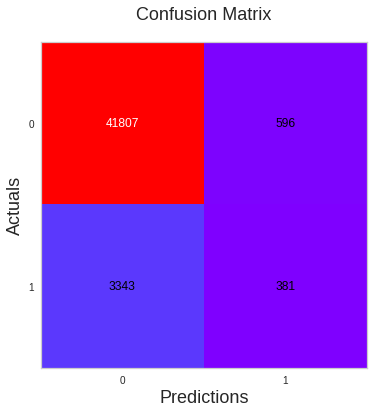

In [ ]:
#Print confusion matrix
confusion_mat_lgbm_test_add_f=confusion_matrix(X_test_data_conf_prob["TARGET"], test_predict_data_add_f["Label"])  
print ("Confusion Matrix - \n")

fig, ax = plot_confusion_matrix(conf_mat=confusion_mat_lgbm_test_add_f, figsize=(6, 6), cmap=plt.cm.rainbow)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

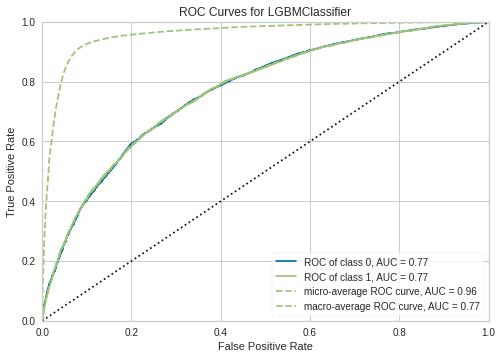

In [ ]:
plot_model(lgbm_additional_features, plot = 'auc')

### 4.1.1 Key highlights
>
>* High degree of overfitting is observed based on difference in the accuracy & AuC scores between predictions on train data and test data.
>
>* Although AuC has increased compared to best_model, accuracy has decreased.
>
>**Based on the above observations, it is concluded that the additional features did not add to the model's predictive power over original dataset.**

## 4.2.0 Stacking-based classifier Model
>
>Just for the sake of evaluation and comparison with a complex model, this stacking classifier is created. It consists of Ada Boost, DT and lightGBM as its estimators.

In [ ]:
#Setup the dataset
data_stacking=setup(data=X_train_data_conf_prob, target="TARGET", test_data=X_test_data_conf_prob, preprocess=False, silent=True)

Description             Value
0              session_id              1468
1                  Target            TARGET
2             Target Type            Binary
3           Label Encoded              None
4           Original Data     (204494, 182)
5          Missing Values             False
6        Numeric Features               181
7    Categorical Features                 0
8   Transformed Train Set     (204494, 181)
9    Transformed Test Set      (46127, 181)
10     Shuffle Train-Test              True
11    Stratify Train-Test             False
12         Fold Generator   StratifiedKFold
13            Fold Number                10
14               CPU Jobs                -1
15                Use GPU             False
16         Log Experiment             False
17        Experiment Name  clf-default-name
18                    USI              021e
19          Fix Imbalance             False
20   Fix Imbalance Method             SMOTE

In [ ]:
# create individual models for stacking
ada=create_model('ada')
dt=create_model('dt')
lightgbm=create_model('lightgbm')

# stacking models
stacker=stack_models(estimator_list = [ada, dt, lightgbm], meta_model=ada)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9298  0.8956  0.2863  0.6644  0.4002  0.3691  0.4063
1       0.9299  0.8937  0.2642  0.6863  0.3815  0.3521  0.3977
2       0.9313  0.8976  0.3066  0.6777  0.4222  0.3912  0.4263
3       0.9320  0.8851  0.3042  0.6916  0.4226  0.3922  0.4299
4       0.9305  0.8954  0.2781  0.6848  0.3956  0.3656  0.4079
5       0.9301  0.8959  0.2327  0.7271  0.3525  0.3258  0.3860
6       0.9307  0.8955  0.3230  0.6538  0.4323  0.3999  0.4283
7       0.9303  0.8908  0.3008  0.6627  0.4138  0.3823  0.4163
8       0.9301  0.8977  0.2769  0.6769  0.3930  0.3628  0.4041
9       0.9299  0.8951  0.2805  0.6710  0.3956  0.3650  0.4045
Mean    0.9305  0.8942  0.2853  0.6796  0.4009  0.3706  0.4107
SD      0.0007  0.0036  0.0242  0.0193  0.0222  0.0209  0.0136

In [ ]:
#Predict on test data
stack_predict_test_conf_prob=predict_model(stacker)
stack_predict_test_conf_prob

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Stacking Classifier     0.913  0.7671  ...  0.1738  0.1414  0.1699

[1 rows x 8 columns]

NAME_HOUSING_TYPE_Municipalapartment  ...   Score
0                                         0  ...  0.5129
1                                         0  ...  0.5226
2                                         0  ...  0.5282
3                                         0  ...  0.5129
4                                         0  ...  0.5193
...                                     ...  ...     ...
46122                                     0  ...  0.7107
46123                                     0  ...  0.5265
46124                                     0  ...  0.5005
46125                                     0  ...  0.5215
46126                                     0  ...  0.5149

[46127 rows x 184 columns]

Confusion Matrix - 



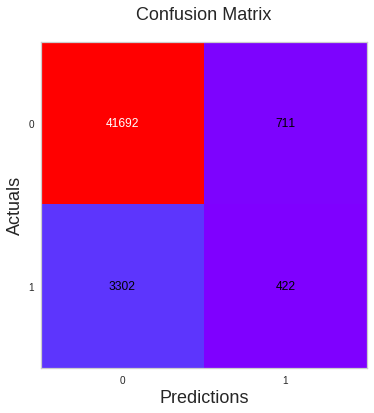

In [ ]:
#Print confusion matrix
confusion_mat_stack_test_conf_prob=confusion_matrix(X_test_data_conf_prob["TARGET"], stack_predict_test_conf_prob["Label"])
print ("Confusion Matrix - \n")
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat_stack_test_conf_prob, figsize=(6, 6), cmap=plt.cm.rainbow)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

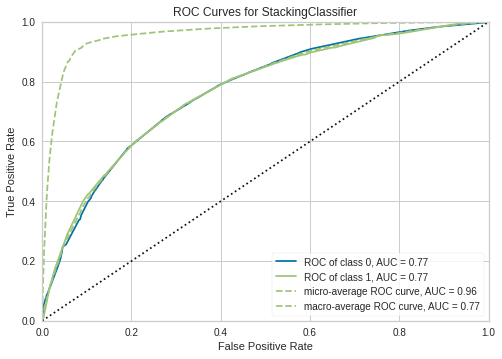

In [ ]:
plot_model(stacker, plot = 'auc')

### 4.2.1 Key highlights
>
>* Overfitting is observed with quite a bit of a difference in accuracy & AuC scores between predictions on train data and test data.
>
>* Though AuC has increased compared to best_model, accuracy has decreased.
>
>**Based on the above observations, it is concluded that the complex staking-based model did not match upto the original best model's predictive power over original dataset.**

## 4.3.0 Neural Network based classifier

In [ ]:
#Define the keras model
NN_model = Sequential()
NN_model.add(Dense(128, input_dim=181, activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(64, activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(32, activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(BatchNormalization())
NN_model.add(Dense(1, activation='sigmoid'))
#Compile the keras model
NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#Fit the keras model on the dataset
NN_model.fit(X_train_data_conf_prob.drop(columns=['TARGET']), X_train_data_conf_prob['TARGET'], epochs=25, batch_size=1024)

Epoch 1/25
200/200 [==============================] - 8s 29ms/step - loss: 0.5461 - accuracy: 0.7829
Epoch 2/25
200/200 [==============================] - 5s 27ms/step - loss: 0.2849 - accuracy: 0.9130
Epoch 3/25
200/200 [==============================] - 5s 26ms/step - loss: 0.2365 - accuracy: 0.9189
Epoch 4/25
200/200 [==============================] - 5s 23ms/step - loss: 0.2207 - accuracy: 0.9203
Epoch 5/25
200/200 [==============================] - 4s 22ms/step - loss: 0.2131 - accuracy: 0.9213
Epoch 6/25
200/200 [==============================] - 4s 21ms/step - loss: 0.2086 - accuracy: 0.9218
Epoch 7/25
200/200 [==============================] - 4s 18ms/step - loss: 0.2049 - accuracy: 0.9224
Epoch 8/25
200/200 [==============================] - 3s 15ms/step - loss: 0.2028 - accuracy: 0.9224
Epoch 9/25
200/200 [==============================] - 3s 15ms/step - loss: 0.2015 - accuracy: 0.9230
Epoch 10/25
200/200 [==============================] - 3s 15ms/step - loss: 0.1998 - accura

In [ ]:
#Print model parameters
print(NN_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               23296     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                      

Accuracy on train data: 92.66% 
Confusion Matrix - 



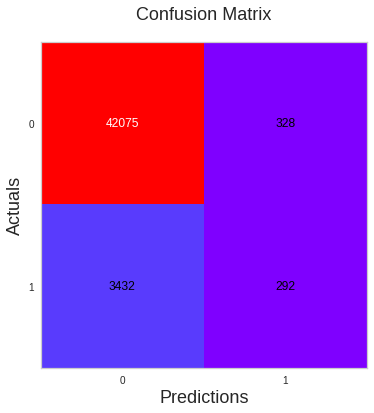

Accuracy on train data: 92.66% 
Accuracy on test data: 91.85%


In [ ]:
#Print accuracy on training data
NN_pred_X_train=(NN_model.predict(X_train_data_conf_prob.drop(columns=['TARGET'])) > 0.5).astype(int)
print("Accuracy on train data: {}% ".format(np.around(accuracy_score(X_train_data_conf_prob['TARGET'], NN_pred_X_train)*100, 2)))

#Print confusion matrix
NN_pred_X_test = (NN_model.predict(X_test_data_conf_prob.drop(columns=['TARGET'])) > 0.5).astype(int)
confusion_mat_NN_test_data_conf_prob=confusion_matrix(X_test_data_conf_prob["TARGET"], NN_pred_X_test)  
print ("Confusion Matrix - \n")

fig, ax = plot_confusion_matrix(conf_mat=confusion_mat_NN_test_data_conf_prob, figsize=(6, 6), cmap=plt.cm.rainbow)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#Print accuracy values on train & test data
print("Accuracy on train data: {}% ".format(np.around(accuracy_score(X_train_data_conf_prob['TARGET'], NN_pred_X_train)*100, 2)))
print("Accuracy on test data: {}%".format(np.around(accuracy_score(X_test_data_conf_prob['TARGET'], NN_pred_X_test)*100, 2)))

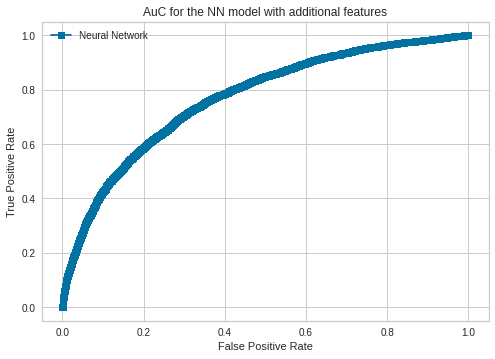

ROC AUC on test data - 0.77


In [ ]:
#Plot AUC (area under curve) for ROC (receiver operating characteristic) curve and print value
probabilities=NN_model.predict(X_test_data_conf_prob.drop(columns=['TARGET']))
fpr, tpr, _=roc_curve(X_test_data_conf_prob['TARGET'], probabilities)
plt.plot(fpr, tpr, marker='s', label='Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("AuC for the NN model with additional features")
plt.show()
print("ROC AUC on test data -", np.around(roc_auc_score(X_test_data_conf_prob['TARGET'], probabilities), 3))

### 4.3.1 Key highlights
>
>* Overfitting is not glaringly noticeable.
>
>**Based on the above model, it is concluded that the NN-based model also did not match up to the model's predictive power over original dataset.**

## 4.4.0 Neural Network based classifier on original dataset
>
>For the sake of sanity check and to check efficacy of NN on the data at hand, Neural Network is trained on original data (dataset with selected features)

In [ ]:
#Define the keras model
model_selected_features=Sequential()
model_selected_features.add(Dense(256, input_dim=176, activation='relu'))
model_selected_features.add(Dropout(0.5))
model_selected_features.add(BatchNormalization())
model_selected_features.add(Dense(128, activation='relu'))
model_selected_features.add(Dropout(0.5))
model_selected_features.add(BatchNormalization())
model_selected_features.add(Dense(64, activation='relu'))
model_selected_features.add(Dropout(0.5))
model_selected_features.add(BatchNormalization())
model_selected_features.add(Dense(32, activation='relu'))
model_selected_features.add(Dropout(0.5))
model_selected_features.add(BatchNormalization())
model_selected_features.add(Dense(1, activation='sigmoid'))

#Compile the keras model
model_selected_features.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the keras model on the dataset
model_selected_features.fit(X_train_selected_features.drop(columns=['TARGET']), y_train_selected_features, epochs=25, batch_size=1024)

Epoch 1/25
200/200 [==============================] - 8s 29ms/step - loss: 0.5642 - accuracy: 0.7423
Epoch 2/25
200/200 [==============================] - 7s 33ms/step - loss: 0.3072 - accuracy: 0.9105
Epoch 3/25
200/200 [==============================] - 11s 56ms/step - loss: 0.2728 - accuracy: 0.9160
Epoch 4/25
200/200 [==============================] - 13s 63ms/step - loss: 0.2659 - accuracy: 0.9168
Epoch 5/25
200/200 [==============================] - 10s 48ms/step - loss: 0.2607 - accuracy: 0.9172
Epoch 6/25
200/200 [==============================] - 9s 43ms/step - loss: 0.2583 - accuracy: 0.9176
Epoch 7/25
200/200 [==============================] - 9s 44ms/step - loss: 0.2563 - accuracy: 0.9178
Epoch 8/25
200/200 [==============================] - 8s 42ms/step - loss: 0.2549 - accuracy: 0.9177
Epoch 9/25
200/200 [==============================] - 9s 44ms/step - loss: 0.2541 - accuracy: 0.9178
Epoch 10/25
200/200 [==============================] - 9s 44ms/step - loss: 0.2527 - acc

In [ ]:
#Print model parameters
print(model_selected_features.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               45312     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_11 (Bat  (None, 128)              512       
 chNormalization)                                     

Confusion Matrix - 



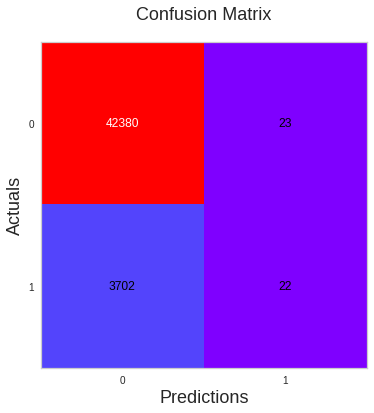

Accuracy on train data - 91.85%
Accuracy on test data - 91.92%


In [ ]:
#Print accuracy on training data
NN_pred_y_train_selected_features=(model_selected_features.predict(X_train_selected_features.drop(columns=['TARGET'])) > 0.5).astype(int)

#Print confusion matrix
NN_pred_y_test_selected_features=(model_selected_features.predict(X_test_selected_features.drop(columns=['TARGET'])) > 0.5).astype(int)
confusion_mat_NN_test_data_selected_features=confusion_matrix(y_test_selected_features, NN_pred_y_test_selected_features)
print ("Confusion Matrix - \n")
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat_NN_test_data_selected_features, figsize=(6, 6), cmap=plt.cm.rainbow)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#Print accuracy on train & test data
print("Accuracy on train data - {}%".format(np.around(accuracy_score(y_train_selected_features, NN_pred_y_train_selected_features)*100, 2)))
print("Accuracy on test data - {}%".format(np.around(accuracy_score(y_test_selected_features, NN_pred_y_test_selected_features)*100, 2)))

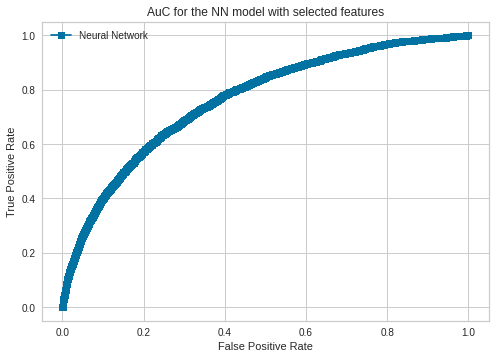

ROC AUC on test data - 0.763


In [ ]:
#Plot AUC (area under curve) for ROC (receiver operating characteristic) curve and print value
probabilities=model_selected_features.predict(X_test_selected_features.drop(columns=['TARGET']))
fpr, tpr, _=roc_curve(y_test_selected_features, probabilities)
plt.plot(fpr, tpr, marker='s', label='Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("AuC for the NN model with selected features")
plt.show()
print("ROC AUC on test data -", np.around(roc_auc_score(y_test_selected_features, probabilities), 3))

### 4.4.1 Key highlights
>
> No new breakthrough is observed and the original best lGBM model holds its position.

# 5.0.0 Summarizing Conclusion
>
>Upon evaluating the myriad of models with varying datasets and feature permutations, it is evidenced that tuned lightGBM is the best performer.
>
>Even deep learning models fared relatively poorly in comparison to the tuned lightGBM model.
>
>With this observation, this phase concludes the model training step. Further the finalised best model shall be deployed in the next phase.